In [1]:
import os, glob
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import pickle
import json
import csv
#import yaml

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from tensorflow.keras import callbacks
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.activations import relu
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

# Summarize trial.json

In [2]:
projname = 'relativeHumidityLong'
fn_save = 'RESULTS_{}.pkl'.format(projname)
dir_results = '/ocean/projects/atm200007p/jlin96/tuning/tools/tuningDirectory'
dir_trials = os.path.join(dir_results, projname, 'trial_*')
print("fn_save:")
print(fn_save)
print("dir_trials:")
print(dir_trials)
# to pandas:
fn_save_pkl = fn_save.split('.')[0] + '.pandas.pkl'
print("fn_save_pkl:")
print(fn_save_pkl)

fn_save:
RESULTS_relativeHumidityLong.pkl
dir_trials:
/ocean/projects/atm200007p/jlin96/tuning/tools/tuningDirectory/relativeHumidityLong/trial_*
fn_save_pkl:
RESULTS_relativeHumidityLong.pandas.pkl


In [4]:
projname = 'specificHumidityLong'
fn_save = 'RESULTS_{}.pkl'.format(projname)
dir_results = '/ocean/projects/atm200007p/jlin96/tuning/tools/tuningDirectory'
dir_trials = os.path.join(dir_results, projname, 'trial_*')
print("fn_save:")
print(fn_save)
print("dir_trials:")
print(dir_trials)
# to pandas:
fn_save_pkl = fn_save.split('.')[0] + '.pandas.pkl'
print("fn_save_pkl:")
print(fn_save_pkl)

fn_save:
RESULTS_specificHumidityLong.pkl
dir_trials:
/ocean/projects/atm200007p/jlin96/tuning/tools/tuningDirectory/specificHumidityLong/trial_*
fn_save_pkl:
RESULTS_specificHumidityLong.pandas.pkl


In [5]:
if not os.path.exists(fn_save):

    RESULTS = {}
    for ktrial in glob.glob(dir_trials):
        trial_id = ktrial.split('/')[-1]    
        
        ### json
        f_json  = ktrial + '/trial.json'
        with open(f_json) as f:
            work = json.load(f)
#         if work['status'] == 'RUNNING':
#             print('Skip %s (incomplete trial)'%trial_id)
#             continue
        
        # num layer
        # make sure your hp name is set correctly, e.g., 'num_layers'
#         num_layers = work['hyperparameters']['values']['num_layers']
        
        # units
        # make sure your hp name is set correctly, e.g., 'units_%d'
        # make sure the index k for units_%d is correct, e.g., k starts from 0 or 1
#         if 'units_%d'%(num_layers+1) not in work['hyperparameters']['values'].keys(): # +1 is for jerry's tuner
#             print('Skip %s (num_layers and #units mismatch)'%trial_id)
#             continue
#         else:
#             units = np.array([work['hyperparameters']['values']['units_%d'%k] for k in range(1,num_layers+2)])
        
        RESULTS[trial_id] = {}
#         RESULTS[trial_id]['num_layers'] = num_layers
#         RESULTS[trial_id]['units'] = units
        
        # other hyperparameters
        # again make sure to the hp names are correct, e.g., 'num_layers', 'units_%d'
        hp_list = work['hyperparameters']['values']
#         hp_list = [k for k, v in hp_list.items() if not k.startswith("unit")] # remove units_%d
#         hp_list = [k for k in hp_list if not k == 'num_layers']
        for khp in hp_list:
            RESULTS[trial_id][khp] = work['hyperparameters']['values'][khp]

        # minimum val_loss
        #print(ktrial)
        #print(work['metrics']['metrics']['val_loss']['observations'])
        RESULTS[trial_id]['min_val_loss'] = work['metrics']['metrics']['val_loss']['observations'][0]['value'][0]
        
        ### csv
        # only if a csv file for epoch-wise metrics were generated.
        if False:
            f_csv = ktrial + '/trial_epoch_metrics_execution-01.csv'

            if os.path.getsize(f_csv)==0: 
                print('Error (no csv): %s'%trial_id)
                del RESULTS[trial_id] 
                continue

            work2 = pd.read_csv(f_csv)['val_loss']
            work2 = work2.rename(trial_id)
            RESULTS[trial_id]['val_loss'] = work2 
            RESULTS[trial_id]['epochs'] = len(work2)

    # Add '# of trainable parameters'
    # make sure the #s of input, output variables
    units_input = 64
    units_output = 60
#     for ktrial in RESULTS.keys():
#         layers = np.array([units_input, *RESULTS[ktrial]['units'], units_output])
#         RESULTS[ktrial]['num_parameters'] = np.sum((layers[:-1]+1) * layers[1:])

    with open(fn_save,"wb") as f:
        pickle.dump(RESULTS, f)
        
else:
    with open(fn_save, 'rb') as f:
        RESULTS = pickle.load(f)
        


RESULTS_PD = pd.DataFrame.from_dict(RESULTS, orient='index')
RESULTS_PD.rename_axis('trial_id', inplace=True)
RESULTS_PD.sort_values('min_val_loss', ascending=True, inplace=True)
RESULTS_PD.reset_index(inplace=True)
RESULTS_PD.index = pd.RangeIndex(RESULTS_PD.index.start+1, RESULTS_PD.index.stop+1)
RESULTS_PD.rename_axis('rank', inplace=True)
RESULTS_PD.to_pickle(fn_save_pkl)

# Reading in pickle files

In [6]:
pd_relative = pd.read_pickle("RESULTS_relativeHumidityLong.pandas.pkl")
pd_specific = pd.read_pickle("RESULTS_specificHumidityLong.pandas.pkl")
summary = {'relative':pd_relative, 'specific':pd_specific}

In [7]:
pd_relative

,trial_id,leak,dropout,lr,hidden_units,num_layers,optimizer,batch_normalization,min_val_loss
rank,,,,,,,,,
1,trial_009,0.133412,0.049385,0.000086,486,10,adam,True,0.001526
2,trial_447,0.232200,0.044768,0.000051,501,5,adam,True,0.001528
3,trial_406,0.055019,0.041498,0.000026,369,5,adam,True,0.001534
4,trial_318,0.169214,0.076837,0.000040,375,4,adam,True,0.001536
5,trial_422,0.121842,0.022106,0.000029,269,6,RMSprop,True,0.001537
...,...,...,...,...,...,...,...,...,...
472,trial_475,0.262394,0.019022,0.000011,240,5,SGD,True,0.048279
473,trial_287,0.292706,0.100644,0.000013,374,8,SGD,True,0.057602
474,trial_070,0.341778,0.075180,0.008684,380,7,RMSprop,False,3690.910889


In [8]:
pd_specific

,trial_id,leak,dropout,lr,hidden_units,num_layers,optimizer,batch_normalization,min_val_loss
rank,,,,,,,,,
1,trial_326,0.098719,0.006089,0.000068,156,6,adam,True,0.001544
2,trial_234,0.385158,0.015882,0.000084,412,4,adam,True,0.001546
3,trial_120,0.369609,0.012126,0.000142,361,4,adam,False,0.001549
4,trial_202,0.300294,0.008645,0.000014,348,5,adam,True,0.001549
5,trial_106,0.300683,0.018025,0.000025,365,7,adam,True,0.001551
...,...,...,...,...,...,...,...,...,...
472,trial_267,0.064259,0.215703,0.007964,505,9,adam,False,0.085814
473,trial_381,0.385675,0.152880,0.007936,227,9,RMSprop,False,0.194111
474,trial_246,0.268279,0.050546,0.004316,455,7,RMSprop,False,2.799710


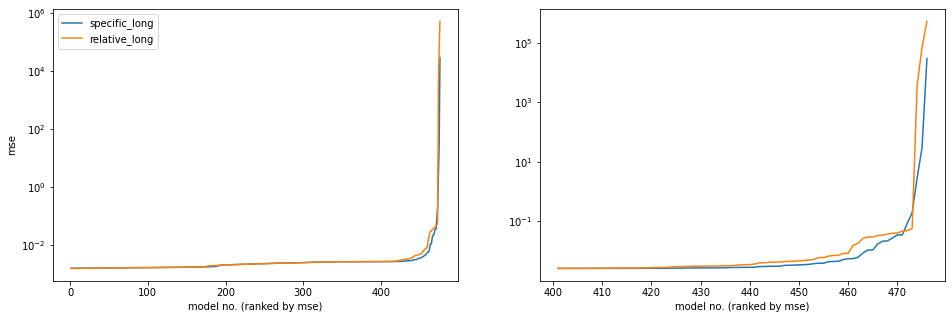

In [10]:
fig, ax_ =  plt.subplots(ncols=2)
ax = ax_[0]
pd_specific['min_val_loss'].plot(ax=ax, label='specific_long')
pd_relative['min_val_loss'].plot(ax=ax, label='relative_long')
ax.set_yscale('log')
ax.set_ylabel('mse')
ax.set_xlabel('model no. (ranked by mse)')
ax.legend()
ax = ax_[1]
pd_specific['min_val_loss'][400:].plot(ax=ax)
pd_relative['min_val_loss'][400:].plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('model no. (ranked by mse)')
fig. set_size_inches(16,5)

In [11]:
len(pd_specific['min_val_loss'])

476

In [12]:
len(pd_relative['min_val_loss'])

476

# Load weight to save h5 model files

In [13]:
def build_model(hp:dict):
    alpha = hp["leak"]
    dp_rate = hp["dropout"]
    model = Sequential()
    hiddenUnits = hp['hidden_units']
    model.add(Dense(units = hiddenUnits, input_dim=64, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha = alpha))
    if hp["batch_normalization"]:
        model.add(BatchNormalization())
    model.add(Dropout(dp_rate))
    for i in range(hp["num_layers"]):
        model.add(Dense(units = hiddenUnits, kernel_initializer='normal'))
        model.add(LeakyReLU(alpha = alpha))
        if hp["batch_normalization"]:
            model.add(BatchNormalization())
        model.add(Dropout(dp_rate))
    model.add(Dense(60, kernel_initializer='normal', activation='linear'))
    initial_learning_rate = hp["lr"]
    optimizer = hp["optimizer"]
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate = initial_learning_rate)
    elif optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate = initial_learning_rate)
    elif optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate = initial_learning_rate)
    elif optimizer == "SGD_momentum":
        optimizer = keras.optimizers.SGD(learning_rate = initial_learning_rate, momentum = .9)
    elif optimizer == "SGD_nesterov":
        optimizer = keras.optimizers.SGD(learning_rate = initial_learning_rate, momentum = .9, nesterov = True)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mse"])
    return model

In [14]:
summary["specific"].loc[1].to_dict()

{'trial_id': 'trial_326',
 'leak': 0.09871906415343866,
 'dropout': 0.00608860187904392,
 'lr': 6.847648148292317e-05,
 'hidden_units': 156,
 'num_layers': 6,
 'optimizer': 'adam',
 'batch_normalization': True,
 'min_val_loss': 0.0015443548327311873}

In [15]:
summary["relative"].loc[1].to_dict()

{'trial_id': 'trial_009',
 'leak': 0.13341153389510066,
 'dropout': 0.04938486290639951,
 'lr': 8.613892194544099e-05,
 'hidden_units': 486,
 'num_layers': 10,
 'optimizer': 'adam',
 'batch_normalization': True,
 'min_val_loss': 0.001526338281109929}

In [16]:
def build_model(hp:dict):
    alpha = hp["leak"]
    dp_rate = hp["dropout"]
    model = Sequential()
    hiddenUnits = hp['hidden_units']
    model.add(Dense(units = hiddenUnits, input_dim=64, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha = alpha))
    if hp["batch_normalization"]:
        model.add(BatchNormalization())
    model.add(Dropout(dp_rate))
    for i in range(hp["num_layers"]):
        model.add(Dense(units = hiddenUnits, kernel_initializer='normal'))
        model.add(LeakyReLU(alpha = alpha))
        if hp["batch_normalization"]:
            model.add(BatchNormalization())
        model.add(Dropout(dp_rate))
    model.add(Dense(60, kernel_initializer='normal', activation='linear'))
    initial_learning_rate = hp["lr"]
    optimizer = hp["optimizer"]
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate = initial_learning_rate)
    elif optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate = initial_learning_rate)
    elif optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate = initial_learning_rate)
    elif optimizer == "SGD_momentum":
        optimizer = keras.optimizers.SGD(learning_rate = initial_learning_rate, momentum = .9)
    elif optimizer == "SGD_nesterov":
        optimizer = keras.optimizers.SGD(learning_rate = initial_learning_rate, momentum = .9, nesterov = True)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mse"])
    return model

def maketxt(family):
    pklPath = "RESULTS_" + family + "HumidityLong.pandas.pkl"
    pd_ranked = pd.read_pickle(pklPath)
    txtpath = "/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/" + family + "Long/"
    for i in range(len(pd_ranked)):
        convert = ["python", "convert_weights.sungduk.py", "--weights_file"]
        model_rank = i+1
        trial_info = pd_ranked.loc[model_rank].to_dict()
        tuning_dir_prefix = '/ocean/projects/atm200007p/jlin96/tuning/tools/tuningDirectory/%sHumidityLong'%family
        model_weights = tuning_dir_prefix + '/%s/checkpoint'%trial_info['trial_id']
        model = build_model(trial_info)
        model.load_weights(model_weights)
        f_save = "/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/" + family + "Longh5/" + '%s_long_model_rank-%04d.h5'%(family, model_rank)
        model.save(f_save)
        txtfile = "Long_Model%04d.txt"%(model_rank)
        convert = convert + [f_save] + ["--output_file"] + [txtpath + family + txtfile]
        os.system(" ".join(convert))


In [17]:
maketxt("specific")

2022-09-13 13:13:15.001627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/jet/home/jlin96/miniconda3/envs/tf/lib/:/jet/home/jlin96/miniconda3/envs/tf/lib/
2022-09-13 13:13:15.002217: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 13:13:15.002427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r029.ib.bridges2.psc.edu): /proc/driver/nvidia/version does not exist
2022-09-13 13:13:15.003226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


In [ ]:
maketxt("relative")

/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


/ocean/projects/atm200007p/jlin96/prognosticTesting/longCoupling/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
